<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Wildfire Data Exploration & Visualization

**Short description:**  
This notebook loads an historical wildfires dataset from Australia, performs basic time-series and regional exploratory analysis, visualizes distributions and trends, and creates a Folium map with region markers.

**Workshop objectives**
- Load and inspect the Historical_Wildfires dataset.
- Create derived features (Year, Month) from the date column.
- Explore temporal trends and per-region statistics for estimated fire area and brightness.
- Visualize distributions, relationships, and region-level summaries using Matplotlib and Seaborn.
- Create an interactive Folium map marking Australian regions of interest.

**Notice about documentation:**  
The original notebook submission (course assignment) was kept intact. I have **only modified documentation (comments, headings, markdown)** and made **minimal, necessary corrections** to ensure the notebook runs without errors. All rights related to the lab/workshop design and original exercise belong exclusively to **IBM Corporation**. This notebook includes additional documentation for clarity, but the intellectual property of the original exercise is retained by IBM.

---

## Table of contents

1. Dependencies & execution instructions  
2. Data loading & initial inspection  
3. Feature engineering (Year, Month)  
4. Temporal trend visualizations  
5. Regional analyses and distributions  
6. Scatterplots and relationships  
7. Folium map of regions  
8. Notes & reproducibility

---

## Dataset

**Historical Wildfires**

This wildfire dataset contains data on fire activities in Australia starting from 2005. Additional information can be found [here](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl).

Variables

- Region: the 7 regions
- Date: in UTC and provide the data for 24 hours ahead
- Estimated_fire_area: daily sum of estimated fire area for presumed vegetation fires with a confidence > 75% for a each region in km2
- Mean_estimated_fire_brightness: daily mean (by flagged fire pixels(=count)) of estimated fire brightness for presumed vegetation fires with a confidence level > 75% in Kelvin
- Mean_estimated_fire_radiative_power: daily mean of estimated radiative power for presumed vegetation fires with a confidence level > 75% for a given region in megawatts
- Mean_confidence: daily mean of confidence for presumed vegetation fires with a confidence level > 75%
- Std_confidence: standard deviation of estimated fire radiative power in megawatts
- Var_confidence: Variance of estimated fire radiative power in megawatts
- Count: daily numbers of pixels for presumed vegetation fires with a confidence level of larger than 75% for a given region
- Replaced: Indicates with an Y whether the data has been replaced with standard quality data when they are available (usually with a 2-3 month lag). Replaced data has a slightly higher quality in terms of locations


## 1) Dependencies & execution instructions

This section installs and imports required Python packages.  

**Recommended local execution steps:**

1. Create and activate a Python virtual environment:
   - `python -m venv venv`
   - `source venv/bin/activate` (macOS / Linux) or `venv\Scripts\activate` (Windows)
2. Install dependencies:
   - `pip install -r requirements.txt`
3. Launch Jupyter Notebook:
   - `jupyter notebook`
4. Open this notebook and run cells top-to-bottom.

**Local execution notes**
- The notebook uses `from js import fetch` and `await fetch(...)` which requires a JavaScript-enabled notebook environment (e.g., JupyterLite / pyodide). If running in a standard local Jupyter environment, replace the `fetch`/`await` logic with `requests.get(URL)` or `pd.read_csv(URL)`.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline
import io
import datetime as dt

## 2) Data loading & initial inspection

This section fetches the CSV from the provided URL into a Pandas DataFrame, confirms read success, and shows first rows and column types.

In [3]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Historical_Wildfires.csv"
df = pd.read_csv(URL)

In [4]:
df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,1/4/2005,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,1/5/2005,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,1/6/2005,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,1/7/2005,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,1/8/2005,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [5]:
df.columns

Index(['Region', 'Date', 'Estimated_fire_area',
       'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power',
       'Mean_confidence', 'Std_confidence', 'Var_confidence', 'Count',
       'Replaced'],
      dtype='object')

In [6]:
df.dtypes

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
dtype: object

## 3) Feature engineering (Year, Month)

This section creates `Year` and `Month` columns from the `Date` field for temporal analysis.

In [7]:
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month

df.dtypes

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
Year                                     int32
Month                                    int32
dtype: object

## 4) Temporal trend visualizations

Plot average estimated fire area over years and over year-month combinations to inspect temporal changes in wildfire extent.


### 4.1 Change in average estimated fire area over time


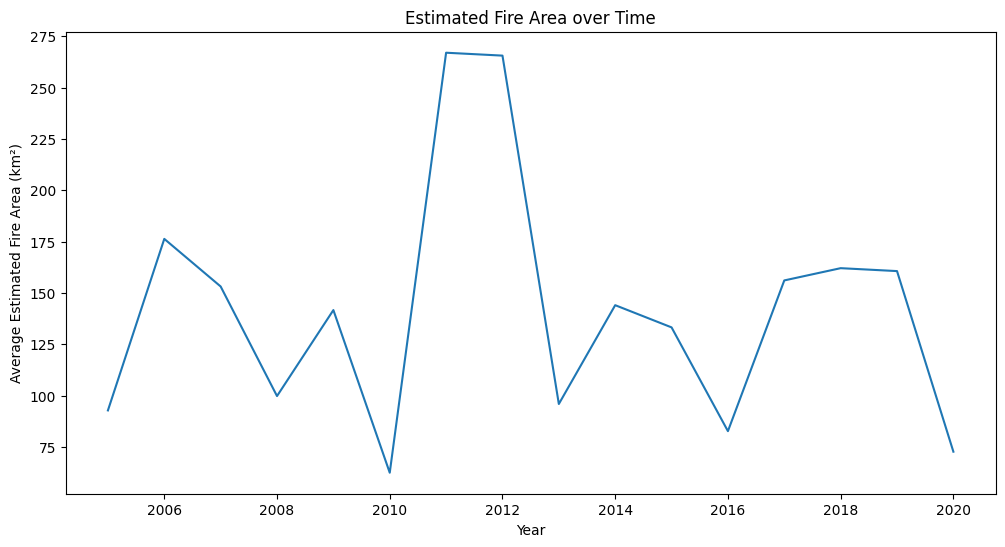

In [8]:
plt.figure(figsize=(12, 6))
df_new=df.groupby('Year')['Estimated_fire_area'].mean()
df_new.plot(x=df_new.index, y=df_new.values)
plt.xlabel('Year')
plt.ylabel('Average Estimated Fire Area (km²)')
plt.title('Estimated Fire Area over Time')
plt.show()

### 4.2 Estimated fire area for year grouped together with month

There is a peak in the previous plot between 2010 to 2013. Let's narrow down our findings.

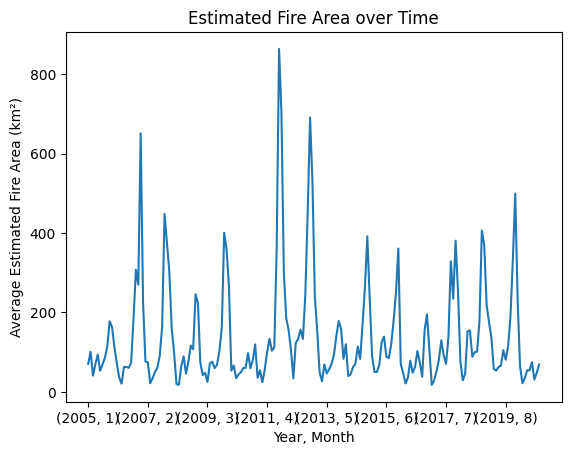

In [9]:
df_new=df.groupby(['Year','Month'])['Estimated_fire_area'].mean()
df_new.plot(x=df_new.index, y=df_new.values)
plt.xlabel('Year, Month')
plt.ylabel('Average Estimated Fire Area (km²)')
plt.title('Estimated Fire Area over Time')
plt.show()

This plot represents that the estimated fire area was on its peak between april, 2011 and the end of 2012. This was the time of maximum wildfire hit in Austrailia.

## 5) Regional analyses and distributions

Explore unique regions, compare mean brightness across regions, and show the composition of pixel counts per region with a pie chart. Also display histogram(s) of brightness.

### 5.1 Distribution of mean estimated fire brightness across the regions


In [10]:
df['Region'].unique()

array(['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'], dtype=object)

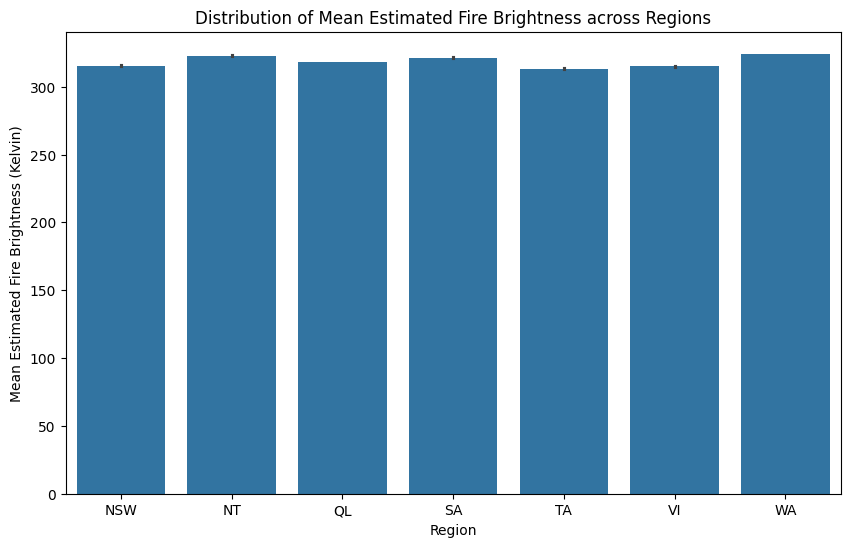

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Region', y='Mean_estimated_fire_brightness')
plt.xlabel('Region')
plt.ylabel('Mean Estimated Fire Brightness (Kelvin)')
plt.title('Distribution of Mean Estimated Fire Brightness across Regions')
plt.show()

### 5.2 Portion of count of pixels for presumed vegetation fires


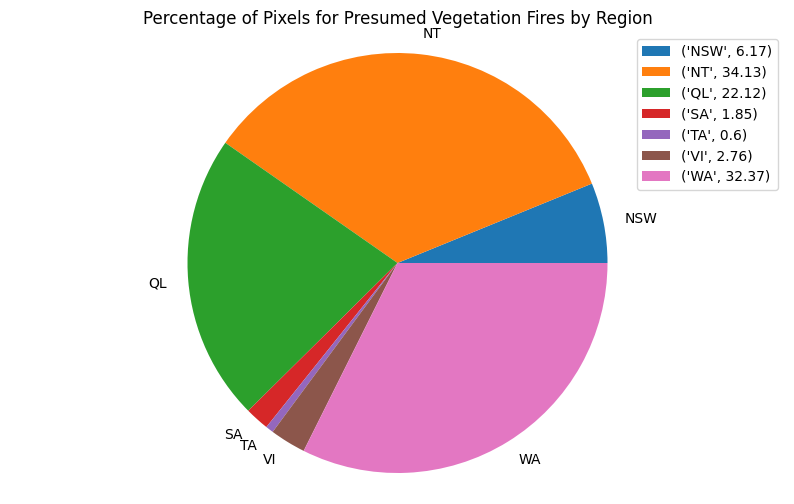

In [13]:
plt.figure(figsize=(10, 6))
region_counts = df.groupby('Region')['Count'].sum()
plt.pie(region_counts, labels=region_counts.index)
plt.title('Percentage of Pixels for Presumed Vegetation Fires by Region')
plt.legend([(i,float(round(k/region_counts.sum()*100,2))) for i,k in zip(region_counts.index, region_counts)])
plt.axis('equal')
plt.show()

### 5.3 Histogram of the mean estimated fire brightness


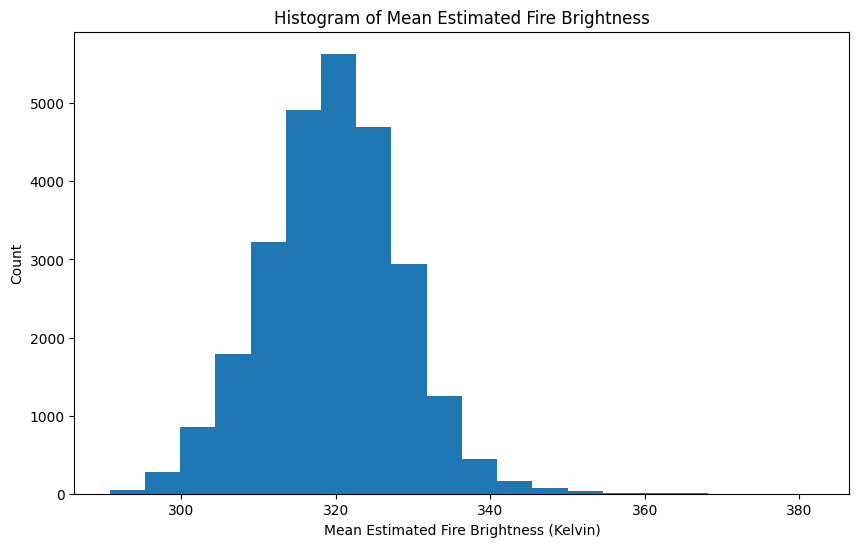

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(x=df['Mean_estimated_fire_brightness'], bins=20)
plt.xlabel('Mean Estimated Fire Brightness (Kelvin)')
plt.ylabel('Count')
plt.title('Histogram of Mean Estimated Fire Brightness')
plt.show()

## 6) Scatterplots and relationships

Plot relationships between `Mean_confidence` and `Mean_estimated_fire_radiative_power` (scatterplots) to detect correlations.

### 6.1 Distribution of estimated fire brightness across regions


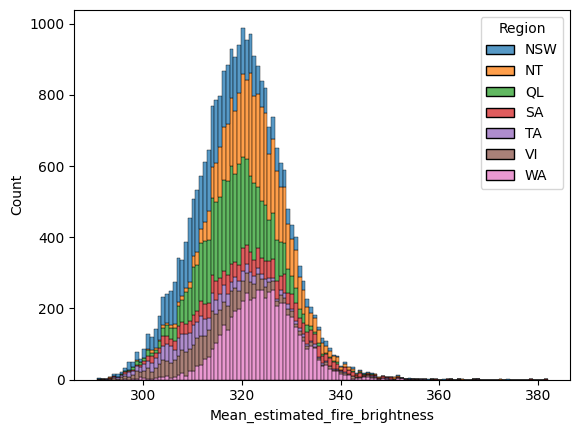

In [15]:
sns.histplot(data=df, x='Mean_estimated_fire_brightness', hue='Region', multiple='stack')
plt.show()

### 6.2 Correlation between mean estimated fire radiative power and mean confidence level


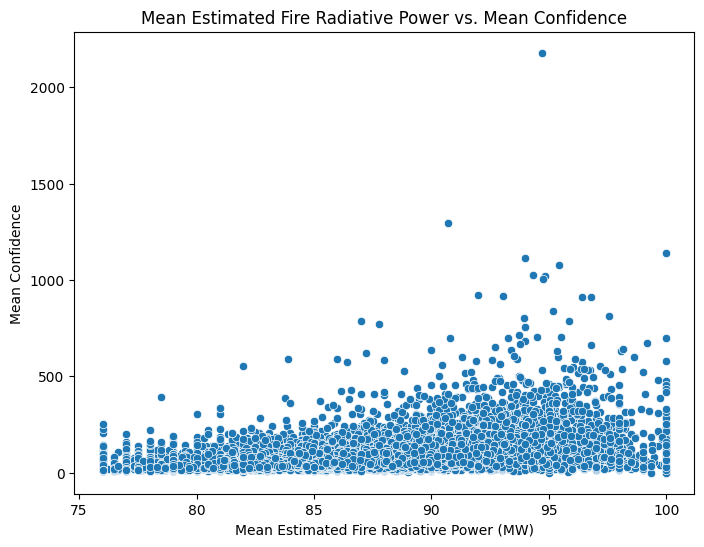

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Mean_confidence', y='Mean_estimated_fire_radiative_power')
plt.xlabel('Mean Estimated Fire Radiative Power (MW)')
plt.ylabel('Mean Confidence')
plt.title('Mean Estimated Fire Radiative Power vs. Mean Confidence')
plt.show()

## 7) Folium map: Australian regions

Create a Folium map centered on Australia and add circle markers for a set of predefined regions (latitude/longitude). This interactive map can be displayed in Jupyter notebook.

In [20]:
region_data = {'region':['NSW','QL','SA','TA','VI','WA','NT'], 'Lat':[-31.8759835,-22.1646782,-30.5343665,-42.035067,-36.5986096,-25.2303005,-19.491411], 
               'Lon':[147.2869493,144.5844903,135.6301212,146.6366887,144.6780052,121.0187246,132.550964]}
reg=pd.DataFrame(region_data)

# instantiate a feature group 
aus_reg = folium.map.FeatureGroup()

# Create a Folium map centered on Australia
Aus_map = folium.Map(location=[-25, 135], zoom_start=4)

# loop through the region and add to feature group
for lat, lng, lab in zip(reg.Lat, reg.Lon, reg.region):
    aus_reg.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lab,
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Aus_map.add_child(aus_reg)

Aus_map.add_child(folium.LayerControl())

Aus_map.save("aus_map.html")

## Authors


[Dr. Pooja](author_link)


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2023-06-281|0.2|Dr. Pooja|Initial Lab Creation|
|2023-05-01|0.1|Shengkai|Create Lab Template|


Copyright © 2023 IBM Corporation. All rights reserved.
